In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import seaborn as sns
import os
import csv

import cv2

from glob import glob
from matplotlib.patches import  Polygon
from matplotlib.collections import PatchCollection
from matplotlib.lines import Line2D
from scipy.stats import linregress
from scipy.spatial.distance import cdist
from scipy.spatial import Delaunay
from scipy.linalg import polar
from itertools import combinations

import sys
sys.path.insert(0, "..")

from utils import geometry
from utils import fileio

In [2]:
dat_files=sorted(glob('C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output/Unstretched_data/20240117_2_IP_GFPCAAX-CheHis_uu_0p5/*/*/Data/*_cell_data_all*.csv'))
mat_dir=sorted(glob('C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output/Unstretched_data/20240117_2_IP_GFPCAAX-CheHis_uu_0p5/*/*/Matrices'))
save_folder='C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output/'
plot_dir = 'C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output/Unstretched_plots/20240117_2_IP_GFPCAAX-CheHis_uu_0p5/'

In [3]:
micron_size=553.57
pixel_size=1024

In [4]:
tm_spot_dat=pd.read_csv('C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\unstretched/Tracked/20240117_2_IP_GFPCAAX-CheHis_uu_0p5_SP/5min_int/traces/green_edges/tm_spots.csv', skiprows=[1,2,3])
tm_track_dat=pd.read_csv('C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\unstretched/Tracked/20240117_2_IP_GFPCAAX-CheHis_uu_0p5_SP/5min_int/traces/green_edges/tm_tracks.csv', skiprows=[1,2,3])
tm_edge_dat=pd.read_csv('C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\unstretched/Tracked/20240117_2_IP_GFPCAAX-CheHis_uu_0p5_SP/5min_int/traces/green_edges/tm_edges.csv', skiprows=[1,2,3])



cols=['cell_id', 'cell_perimeter_microns', 'cell_area_microns',
       'shape_parameter', 'circularity', 'cell_edge_count',
       'major_shape_axis_alignment_rads', 'cc_x', 'cc_y', 'track_id', 'spot_id', 'time', 'tm_frame']
dat_df=pd.DataFrame(columns=cols)
for i in range(len(dat_files)):
    tm=tm_spot_dat[tm_spot_dat.FRAME==i][['ID','TRACK_ID', 'POSITION_X', 'POSITION_Y', 'FRAME']]

    A=np.loadtxt(glob(mat_dir[i]+'/*Matrix_A*.txt')[0])
    B=np.loadtxt(glob(mat_dir[i]+'/*Matrix_B*.txt')[0])
    C=np.loadtxt(glob(mat_dir[i]+'/*Matrix_C*.txt')[0])
    R=np.loadtxt(glob(mat_dir[i]+'/*Matrix_R*.txt')[0])

    dat=pd.read_csv(dat_files[i])

    cell_edge_count=geometry.get_edge_count(B)
    cell_centres=geometry.get_cell_centres(C,R,cell_edge_count)



    scale_factor=1.03

    cc=np.vstack((cell_centres[:,0]-np.mean(cell_centres[:,0]),cell_centres[:,1]-np.mean(cell_centres[:,1]))).T
    tm_cc=scale_factor*np.vstack((tm.POSITION_X-np.mean(tm.POSITION_X), -tm.POSITION_Y-np.mean(-tm.POSITION_Y))).T

    # plt.scatter(cc[:,0], cc[:,1])
    # plt.scatter(tm_cc[:,0], tm_cc[:,1])
    # plt.title(str(i))
    # plt.show()

    dists=cdist(cc, tm_cc)
    min_id=np.where(dists==np.min(dists, axis=0))[1]

    dat['cc_x']=cc[:,0]
    dat['cc_y']=cc[:,1]
    dat['track_id']=np.array(tm.TRACK_ID.iloc[min_id])
    dat['spot_id']=np.array(tm.ID.iloc[min_id])
    dat['tm_frame']=np.array(tm.FRAME.iloc[min_id])
    dat['time']=dat['tm_frame']*5
    


    dat_df=pd.concat([dat_df,dat], ignore_index=True)


dat_df["parent_id"] = np.nan
dat_df["divisions"] = 0

t_id=np.max(dat_df.track_id)
Nc_orig=t_id
max_splits=np.max(tm_track_dat.NUMBER_SPLITS)


for s in tm_track_dat[tm_track_dat.NUMBER_SPLITS>0].TRACK_ID:

    
    splits=np.array(tm_track_dat[tm_track_dat.TRACK_ID==s].NUMBER_SPLITS)[0]

    split=np.where(np.unique(dat_df[dat_df.track_id==s].tm_frame,return_counts=True)[1]>1)[0][0]


    edges=tm_edge_dat[tm_edge_dat.TRACK_ID==s]
    n_edges=edges[edges.EDGE_TIME==split-0.5][['EDGE_TIME','SPOT_SOURCE_ID','SPOT_TARGET_ID']]
    track_a=[]
    track_b=[]
    track_a.append(n_edges.SPOT_TARGET_ID.iloc[0])
    track_b.append(n_edges.SPOT_TARGET_ID.iloc[1])
    
    for i in range(split+1,len(dat_files)):
        n_edges=edges[edges.EDGE_TIME==i-0.5][['EDGE_TIME','SPOT_SOURCE_ID','SPOT_TARGET_ID']]
        t_a=list(n_edges[n_edges.SPOT_SOURCE_ID.isin(track_a)].SPOT_TARGET_ID)
        t_b=list(n_edges[n_edges.SPOT_SOURCE_ID.isin(track_b)].SPOT_TARGET_ID)
        track_a=track_a+t_a
        track_b=track_b+t_b
    
    new_id_a=t_id+1
    new_id_b=t_id+2

    dat_df.loc[dat_df["spot_id"].isin(track_a), "track_id"]=new_id_a
    dat_df.loc[dat_df["spot_id"].isin(track_b), "track_id"]=new_id_b
    dat_df.loc[(dat_df["spot_id"].isin(track_a))|(dat_df["spot_id"].isin(track_b)), "parent_id"]=s
    dat_df.loc[(dat_df["spot_id"].isin(track_a))|(dat_df["spot_id"].isin(track_b)), "divisions"]+=1
    tm_edge_dat.loc[tm_edge_dat["SPOT_SOURCE_ID"].isin(track_a), "TRACK_ID"]=new_id_a
    tm_edge_dat.loc[tm_edge_dat["SPOT_SOURCE_ID"].isin(track_b), "TRACK_ID"]=new_id_b




    t_id=t_id+2

    if splits>1:
        if(len(np.where(np.unique(dat_df[dat_df.track_id==new_id_a].tm_frame,return_counts=True)[1]>1)[0])>0):
                split=np.unique(dat_df[dat_df.track_id==new_id_a].tm_frame,return_counts=True)[0][np.where(np.unique(dat_df[dat_df.track_id==new_id_a].tm_frame,return_counts=True)[1]>1)[0][0]]

                edges=tm_edge_dat[tm_edge_dat.TRACK_ID==new_id_a]
                n_edges=edges[edges.EDGE_TIME==split-0.5][['EDGE_TIME','SPOT_SOURCE_ID','SPOT_TARGET_ID']]
                track_a=[]
                track_b=[]
                track_a.append(n_edges.SPOT_TARGET_ID.iloc[0])
                track_b.append(n_edges.SPOT_TARGET_ID.iloc[1])

                for i in range(split+1,len(dat_files)):
                    n_edges=edges[edges.EDGE_TIME==i-0.5][['EDGE_TIME','SPOT_SOURCE_ID','SPOT_TARGET_ID']]
                    t_a=list(n_edges[n_edges.SPOT_SOURCE_ID.isin(track_a)].SPOT_TARGET_ID)
                    t_b=list(n_edges[n_edges.SPOT_SOURCE_ID.isin(track_b)].SPOT_TARGET_ID)
                    track_a=track_a+t_a
                    track_b=track_b+t_b

                new_id_aa=t_id+1
                new_id_bb=t_id+2

                dat_df.loc[dat_df["spot_id"].isin(track_a), "track_id"]=new_id_aa
                dat_df.loc[dat_df["spot_id"].isin(track_b), "track_id"]=new_id_bb
                dat_df.loc[(dat_df["spot_id"].isin(track_a))|(dat_df["spot_id"].isin(track_b)), "parent_id"]=new_id_a
                dat_df.loc[(dat_df["spot_id"].isin(track_a))|(dat_df["spot_id"].isin(track_b)), "divisions"]+=1
                tm_edge_dat.loc[tm_edge_dat["SPOT_SOURCE_ID"].isin(track_a), "TRACK_ID"]=new_id_aa
                tm_edge_dat.loc[tm_edge_dat["SPOT_SOURCE_ID"].isin(track_b), "TRACK_ID"]=new_id_bb

                t_id=t_id+2

        if(len(np.where(np.unique(dat_df[dat_df.track_id==new_id_b].tm_frame,return_counts=True)[1]>1)[0]) >0):
                split=np.unique(dat_df[dat_df.track_id==new_id_b].tm_frame,return_counts=True)[0][np.where(np.unique(dat_df[dat_df.track_id==new_id_b].tm_frame,return_counts=True)[1]>1)[0][0]]

                edges=tm_edge_dat[tm_edge_dat.TRACK_ID==new_id_b]
                n_edges=edges[edges.EDGE_TIME==split-0.5][['EDGE_TIME','SPOT_SOURCE_ID','SPOT_TARGET_ID']]
                track_a=[]
                track_b=[]
                track_a.append(n_edges.SPOT_TARGET_ID.iloc[0])
                track_b.append(n_edges.SPOT_TARGET_ID.iloc[1])

                for i in range(split+1,len(dat_files)):
                    n_edges=edges[edges.EDGE_TIME==i-0.5][['EDGE_TIME','SPOT_SOURCE_ID','SPOT_TARGET_ID']]
                    t_a=list(n_edges[n_edges.SPOT_SOURCE_ID.isin(track_a)].SPOT_TARGET_ID)
                    t_b=list(n_edges[n_edges.SPOT_SOURCE_ID.isin(track_b)].SPOT_TARGET_ID)
                    track_a=track_a+t_a
                    track_b=track_b+t_b

                new_id_aa=t_id+1
                new_id_bb=t_id+2

                dat_df.loc[dat_df["spot_id"].isin(track_a), "track_id"]=new_id_aa
                dat_df.loc[dat_df["spot_id"].isin(track_b), "track_id"]=new_id_bb
                dat_df.loc[(dat_df["spot_id"].isin(track_a))|(dat_df["spot_id"].isin(track_b)), "parent_id"]=new_id_b
                dat_df.loc[(dat_df["spot_id"].isin(track_a))|(dat_df["spot_id"].isin(track_b)), "divisions"]+=1
                tm_edge_dat.loc[tm_edge_dat["SPOT_SOURCE_ID"].isin(track_a), "TRACK_ID"]=new_id_aa
                tm_edge_dat.loc[tm_edge_dat["SPOT_SOURCE_ID"].isin(track_b), "TRACK_ID"]=new_id_bb

                t_id=t_id+2

dat_df=dat_df.rename(columns={"cell_id": "cell_id_old", "track_id": "cell_id_new"})
dat_df['angle_horizontal']=abs(np.where(dat_df.major_shape_axis_alignment_rads<np.pi/2,dat_df.major_shape_axis_alignment_rads, dat_df.major_shape_axis_alignment_rads-np.pi))
dat_df['cc_x']=dat_df['cc_x']*(micron_size/pixel_size)
dat_df['cc_y']=dat_df['cc_y']*(micron_size/pixel_size)
dat_df.to_csv(save_folder+"/20240117_2_IP_GFPCAAX-CheHis_uu_0p5_SP_pooled_mech.csv",index=False)

In [6]:
dat_df=dat_df.sort_values(['time', 'cell_id_new']).reset_index(drop=True)
dat_df['area_norm']=dat_df.cell_area_microns/(dat_df.groupby('cell_id_new').cell_area_microns.transform('first'))
dat_df['perimeter_norm']=dat_df.cell_perimeter_microns/(dat_df.groupby('cell_id_new').cell_perimeter_microns.transform('first'))
dat_df['circularity_norm']=dat_df.circularity/(dat_df.groupby('cell_id_new').circularity.transform('first'))

In [7]:
orig_cells=dat_df[dat_df.cell_id_new<=Nc_orig]


div_list=np.unique(dat_df.parent_id)[~np.isnan(np.unique(dat_df.parent_id))]

#no_div=orig_cells[~orig_cells.cell_id_new.isin(np.where(tm_track_dat.NUMBER_SPLITS>0)[0])]
no_div=dat_df[dat_df.cell_id_new.isin(np.where(dat_df.groupby('cell_id_new').count().time==len(dat_files))[0])]



div_cells=dat_df[(dat_df.cell_id_new.isin(div_list))]
daughter_cells=dat_df[dat_df.cell_id_new>Nc_orig]

In [9]:
cell_dat=dat_df.groupby('cell_id_new').min().time.to_frame()
dat_mi=dat_df.set_index(['cell_id_new','time'])
dat_mi['dx0']=dat_mi.cc_x-dat_df.groupby('cell_id_new').first().cc_x
dat_mi['dy0']=dat_mi.cc_y-dat_df.groupby('cell_id_new').first().cc_y
dat_mi['ds0']=np.sqrt(dat_mi.dx0**2 +dat_mi.dy0**2)
dat_mi['ds0_sq']=dat_mi.dx0**2 +dat_mi.dy0**2
cell_dat['MSD']=dat_mi.groupby('cell_id_new').mean().ds0_sq

C:\Users\v35431nc\AppData\Local\Temp\ipykernel_38740\3339878596.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cell_dat['MSD']=dat_mi.groupby('cell_id_new').mean().ds0_sq


C:\Users\v35431nc\AppData\Local\Temp\ipykernel_38740\4028117221.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  g=sns.histplot(data=cell_dat,x='MSD', stat='probability',element="step", palette=sns.husl_palette(1,l=.4))


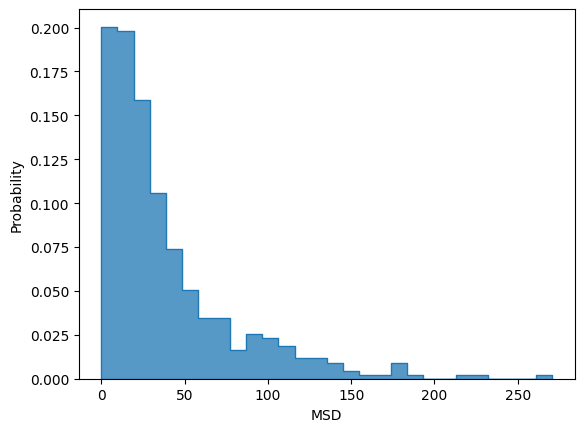

In [10]:
fig, ax=plt.subplots()
g=sns.histplot(data=cell_dat,x='MSD', stat='probability',element="step", palette=sns.husl_palette(1,l=.4))


plt.savefig(plot_dir+'/MSD.png', dpi=300, bbox_inches='tight')

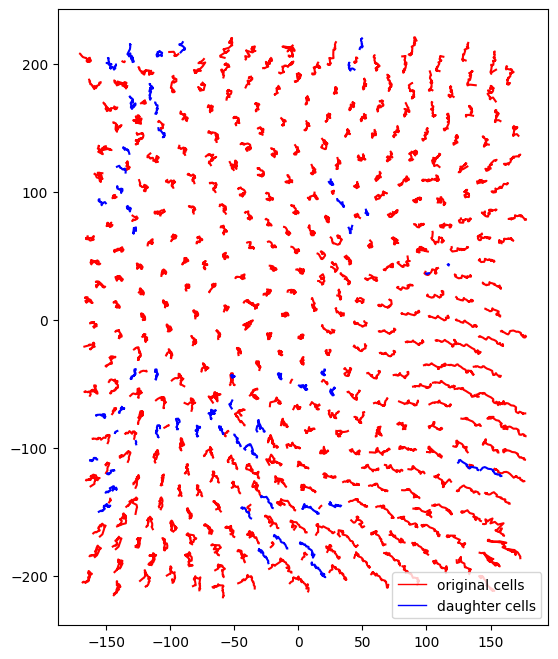

In [11]:
fig,ax=plt.subplots(figsize=(8, 8))
for i in (np.unique(dat_df.cell_id_new)):
    ax.plot(orig_cells[orig_cells.cell_id_new==i].cc_x, orig_cells[orig_cells.cell_id_new==i].cc_y, c='red', label='original cells')
    ax.plot(daughter_cells[daughter_cells.cell_id_new==i].cc_x, daughter_cells[daughter_cells.cell_id_new==i].cc_y, c='blue', label=daughter_cells)

ax.set_aspect('equal')
legend_elements = [Line2D([0], [0], color='r', lw=1, label='original cells'),
                  Line2D([0], [0], color='b', lw=1, label='daughter cells')]
ax.legend(handles=legend_elements)
plt.savefig(plot_dir+'/cell_tracks.png', dpi=300, bbox_inches='tight')

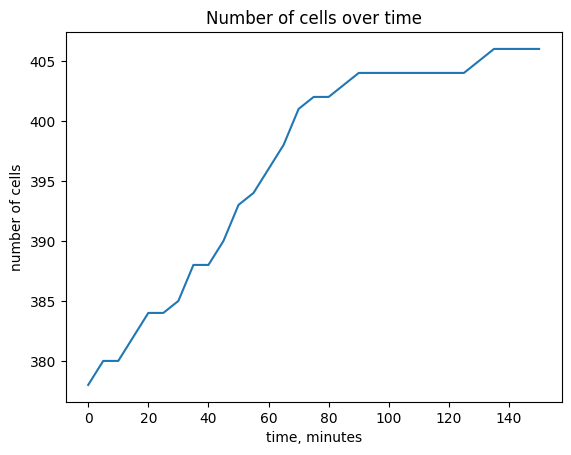

In [12]:
plt.plot(dat_df.groupby('time').count().cell_id_new)
#plt.axvline(80, c='r', linestyle='--')
plt.xlabel('time, minutes')
plt.ylabel('number of cells')
plt.title("Number of cells over time")

plt.savefig(plot_dir+'/Number_cells_time.png', dpi=300, bbox_inches='tight')

In [13]:
dat_df

,cell_id_old,cell_perimeter_microns,cell_area_microns,shape_parameter,circularity,cell_edge_count,major_shape_axis_alignment_rads,cc_x,cc_y,cell_id_new,spot_id,time,tm_frame,parent_id,divisions,angle_horizontal,area_norm,perimeter_norm,circularity_norm
0,112.0,66.409843,254.309091,4.164391,0.289642,5.0,2.553349,163.152961,383.725603,0,2004,0,0,NaN,0,0.588244,1.000000,1.000000,1.000000
1,359.0,93.188130,595.876799,3.817529,0.438186,7.0,0.385343,-301.361324,378.125603,1,2003,0,0,NaN,0,0.385343,1.000000,1.000000,1.000000
2,272.0,76.075376,389.735636,3.853533,0.475426,6.0,1.057541,-75.980372,375.958936,2,2005,0,0,NaN,0,1.057541,1.000000,1.000000,1.000000
3,270.0,90.022336,551.222641,3.834306,0.523924,6.0,0.260470,-250.647039,372.958936,3,2006,0,0,NaN,0,0.260470,1.000000,1.000000,1.000000
4,356.0,86.589940,509.203810,3.837263,0.431321,7.0,1.082513,81.067247,372.697031,4,2007,0,0,NaN,0,1.082513,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12284,10.0,60.478001,243.035746,3.879380,0.681902,5.0,1.288528,-43.221736,-351.151847,429,14744,150,30,346.0,1,1.288528,1.304006,1.110456,1.176053
12285,101.0,64.417293,277.880630,3.864322,0.684298,6.0,2.430183,35.178264,-369.118514,430,14752,150,30,350.0,1,0.711410,0.980879,1.008811,1.100884
12286,110.0,69.748468,331.172806,3.832722,0.563071,6.0,0.683479,23.178264,-338.785181,431,14738,150,30,350.0,1,0.683479,1.090646,1.060312,0.880310
12287,397.0,76.168221,410.964662,3.757263,0.604098,7.0,1.512920,-166.821736,400.905296,432,14083,150,30,376.0,1,1.512920,1.125953,1.061630,0.714742


In [13]:
nd_t0=no_div[no_div.tm_frame==0][['cell_id_new','cc_x', 'cc_y', 'tm_frame']]
nd_t150=no_div[no_div.tm_frame==30][['cell_id_new','cc_x', 'cc_y', 'tm_frame']]
cc_nd=pd.merge(nd_t0, nd_t150, on='cell_id_new', suffixes=("_0", "_150"))
cc_nd['cc_dx']=cc_nd.cc_x_150-cc_nd.cc_x_0
cc_nd['cc_dy']=cc_nd.cc_y_150-cc_nd.cc_y_0

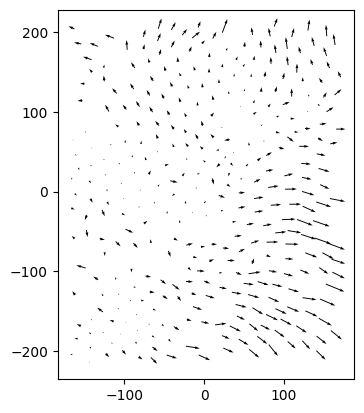

In [14]:
dx= cc_nd.cc_dx
dy=cc_nd.cc_dy


mag=np.sqrt(np.asarray(dx)**2+np.asarray(dy)**2)

plt.quiver(cc_nd.cc_x_0,cc_nd.cc_y_0, dx, dy,units='xy', angles='xy', scale=1, zorder=10)






#plt.quiver(cc_sr.cc_x_s,cc_sr.cc_y_s, dx, dy,units='xy', angles='xy', scale=1, zorder=10, color='red')
#plt.xlim(-200,200)
#plt.ylim(-350,350)


plt.gca().set_aspect('equal')
plt.savefig(plot_dir+'/cell_centre_displacement.png', dpi=300, bbox_inches='tight')

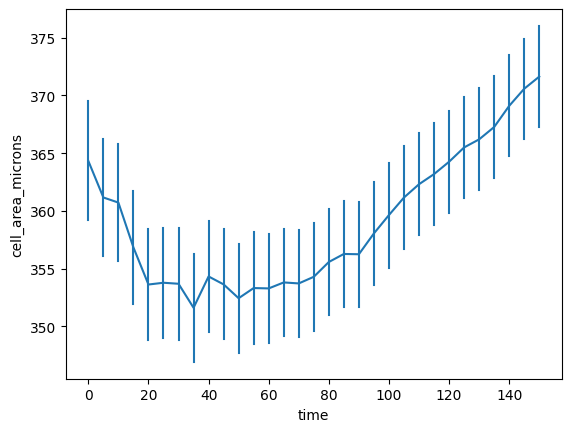

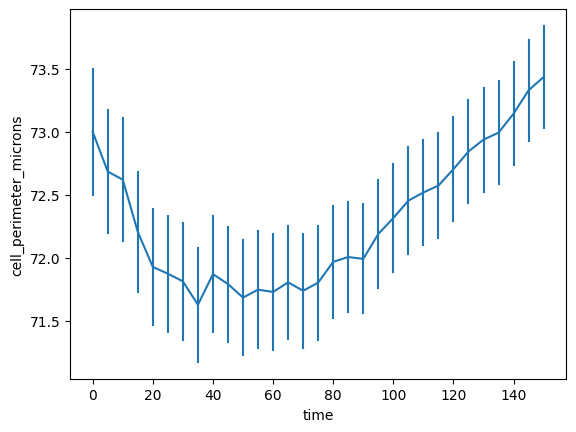

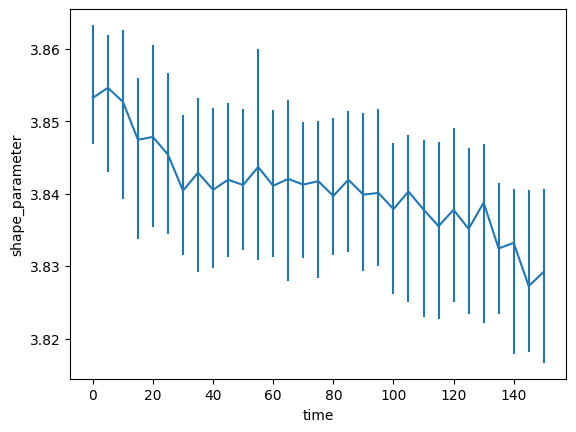

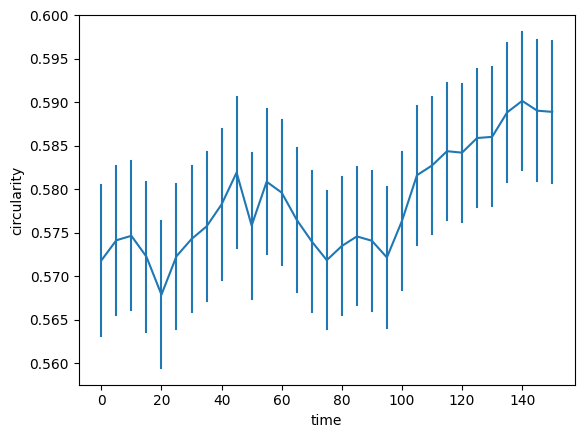

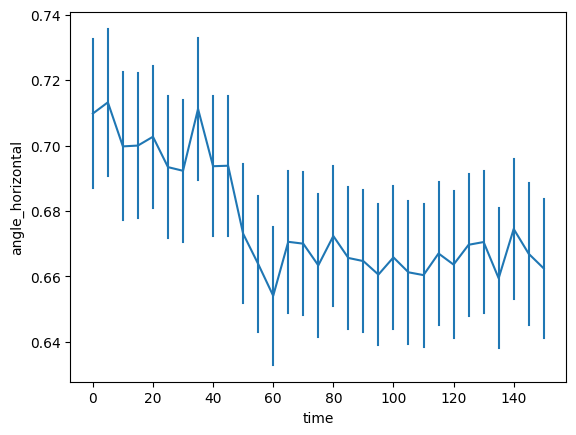

In [15]:
sns.lineplot(data=dat_df, y='cell_area_microns', x='time',err_style='bars', errorbar='se')
#plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/mean_cell_area_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='cell_perimeter_microns', x='time',err_style='bars', errorbar='se')
#plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/mean_cell_perimeter_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='shape_parameter', x='time',err_style='bars', estimator='median')
#plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/median_shape_parameter_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='circularity', x='time',err_style='bars', errorbar='se')
#plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/mean_circularity_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='angle_horizontal', x='time',err_style='bars', errorbar='se')
#plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/mean_angle_horizontal_time.png', dpi=300, bbox_inches='tight')
plt.show()

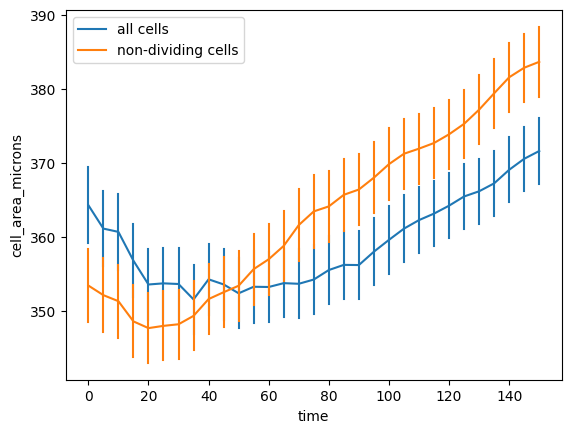

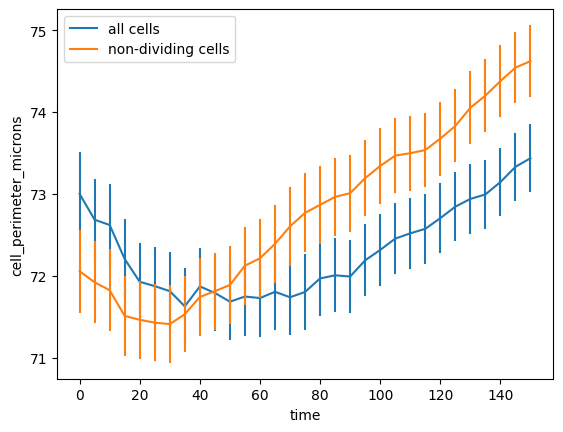

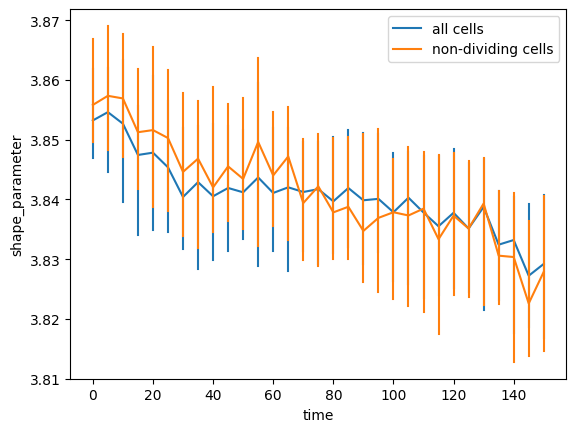

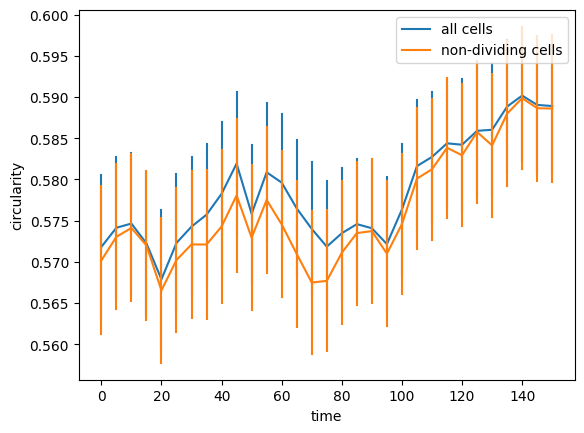

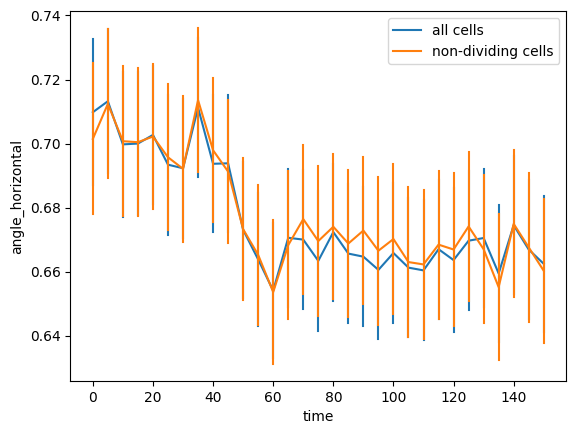

In [17]:
sns.lineplot(data=dat_df, y='cell_area_microns', x='time',err_style='bars', errorbar='se', label='all cells')
sns.lineplot(data=no_div, y='cell_area_microns', x='time',err_style='bars', errorbar='se', label='non-dividing cells')
plt.legend()
#plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/compare_mean_cell_area_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='cell_perimeter_microns', x='time',err_style='bars', errorbar='se', label='all cells')
sns.lineplot(data=no_div, y='cell_perimeter_microns', x='time',err_style='bars', errorbar='se', label='non-dividing cells')
plt.legend()
#plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/compare_mean_cell_perimeter_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='shape_parameter', x='time',err_style='bars', estimator='median', label='all cells')
sns.lineplot(data=no_div, y='shape_parameter', x='time',err_style='bars', estimator='median', label='non-dividing cells')
plt.legend()
#plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/compare_median_shape_parameter_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='circularity', x='time',err_style='bars', errorbar='se', label='all cells')
sns.lineplot(data=no_div, y='circularity', x='time',err_style='bars', errorbar='se', label='non-dividing cells')
plt.legend()
#plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/compare_mean_circularity_time.png', dpi=300, bbox_inches='tight')
plt.show()
sns.lineplot(data=dat_df, y='angle_horizontal', x='time',err_style='bars', errorbar='se', label='all cells')
sns.lineplot(data=no_div, y='angle_horizontal', x='time',err_style='bars', errorbar='se', label='non-dividing cells')
plt.legend()
#plt.axvline(80, c='r', linestyle='--', linewidth=0.75)
plt.savefig(plot_dir+'/compare_mean_angle_horizontal_time.png', dpi=300, bbox_inches='tight')
plt.show()

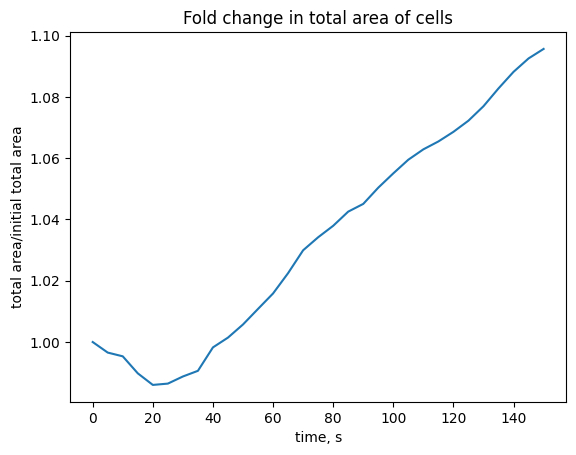

In [18]:
t=np.linspace(0, 150, 31)
plt.plot(t,dat_df.groupby('time').cell_area_microns.sum()/(dat_df[dat_df.time==0].sum().cell_area_microns))
#plt.axvline(80, linestyle='--', color='red')
plt.xlabel("time, s")
plt.ylabel("total area/initial total area")
plt.title("Fold change in total area of cells")
plt.savefig(plot_dir+'/total_area.png', dpi=300, bbox_inches='tight')

plt.show()

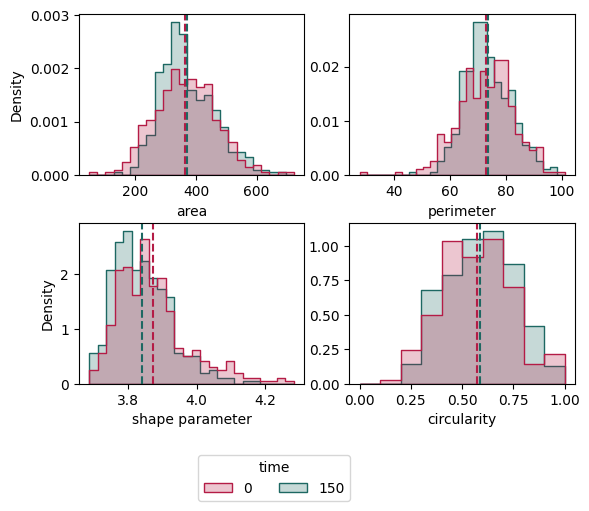

In [19]:
fig, ax=plt.subplots(2,2)
g=sns.histplot(data=dat_df[(dat_df.time ==0) | (dat_df.time==150)], hue='time',x='cell_area_microns', stat='density',element="step", palette=sns.husl_palette(2,l=.4), ax=ax[0,0], legend=False)
ax[0,0].axvline(np.mean(dat_df[dat_df.time ==0].cell_area_microns), c=sns.husl_palette(2,l=.4)[0], linestyle='--')
#ax[0,0].axvline(np.mean(dat_df[dat_df.time ==80].cell_area_microns), c=sns.husl_palette(3,l=.4)[1], linestyle='--')
ax[0,0].axvline(np.mean(dat_df[dat_df.time ==150].cell_area_microns), c=sns.husl_palette(2,l=.4)[1], linestyle='--')

g=sns.histplot(data=dat_df[(dat_df.time ==0) | (dat_df.time==150)], hue='time',x='cell_perimeter_microns', stat='density', element="step", palette=sns.husl_palette(2,l=.4), ax=ax[0,1], legend=False)
ax[0,1].axvline(np.mean(dat_df[dat_df.time ==0].cell_perimeter_microns), c=sns.husl_palette(2,l=.4)[0], linestyle='--')
#ax[0,1].axvline(np.mean(dat_df[dat_df.time ==80].cell_perimeter_microns), c=sns.husl_palette(3,l=.4)[1], linestyle='--')
ax[0,1].axvline(np.mean(dat_df[dat_df.time ==150].cell_perimeter_microns), c=sns.husl_palette(2,l=.4)[1], linestyle='--')

g=sns.histplot(data=dat_df[(dat_df.time ==0) | (dat_df.time==150)], hue='time',x='circularity', stat='density', element="step", palette=sns.husl_palette(2,l=.4), ax=ax[1,1], legend=False , binrange=[0,1], bins=10)
ax[1,1].axvline(np.mean(dat_df[dat_df.time ==0].circularity), c=sns.husl_palette(2,l=.4)[0], linestyle='--')
#ax[1,1].axvline(np.mean(dat_df[dat_df.time ==80].circularity), c=sns.husl_palette(3,l=.4)[1], linestyle='--')
ax[1,1].axvline(np.mean(dat_df[dat_df.time ==150].circularity), c=sns.husl_palette(2,l=.4)[1], linestyle='--')

g=sns.histplot(data=dat_df[(dat_df.time ==0) |(dat_df.time==150)], hue='time',x='shape_parameter', stat='density', element="step", palette=sns.husl_palette(2,l=.4), ax=ax[1,0], legend=True)
ax[1,0].axvline(np.mean(dat_df[dat_df.time ==0].shape_parameter), c=sns.husl_palette(2,l=.4)[0], linestyle='--')
#ax[1,0].axvline(np.mean(dat_df[dat_df.time ==80].shape_parameter), c=sns.husl_palette(3,l=.4)[1], linestyle='--')
ax[1,0].axvline(np.mean(dat_df[dat_df.time ==150].shape_parameter), c=sns.husl_palette(2,l=.4)[1], linestyle='--')

plt.subplots_adjust(hspace=0.3)
ax[0,1].set_ylabel('')
ax[1,1].set_ylabel('')

ax[0,1].set_xlabel('perimeter')
ax[1,1].set_xlabel('circularity')
ax[1,0].set_xlabel('shape parameter')
ax[0,0].set_xlabel('area')
sns.move_legend(g, "upper left", bbox_to_anchor=(0.5, -0.4), frameon=True, ncol=3)
plt.savefig(plot_dir+'/cell_quantities_hists.png', dpi=300, bbox_inches='tight')

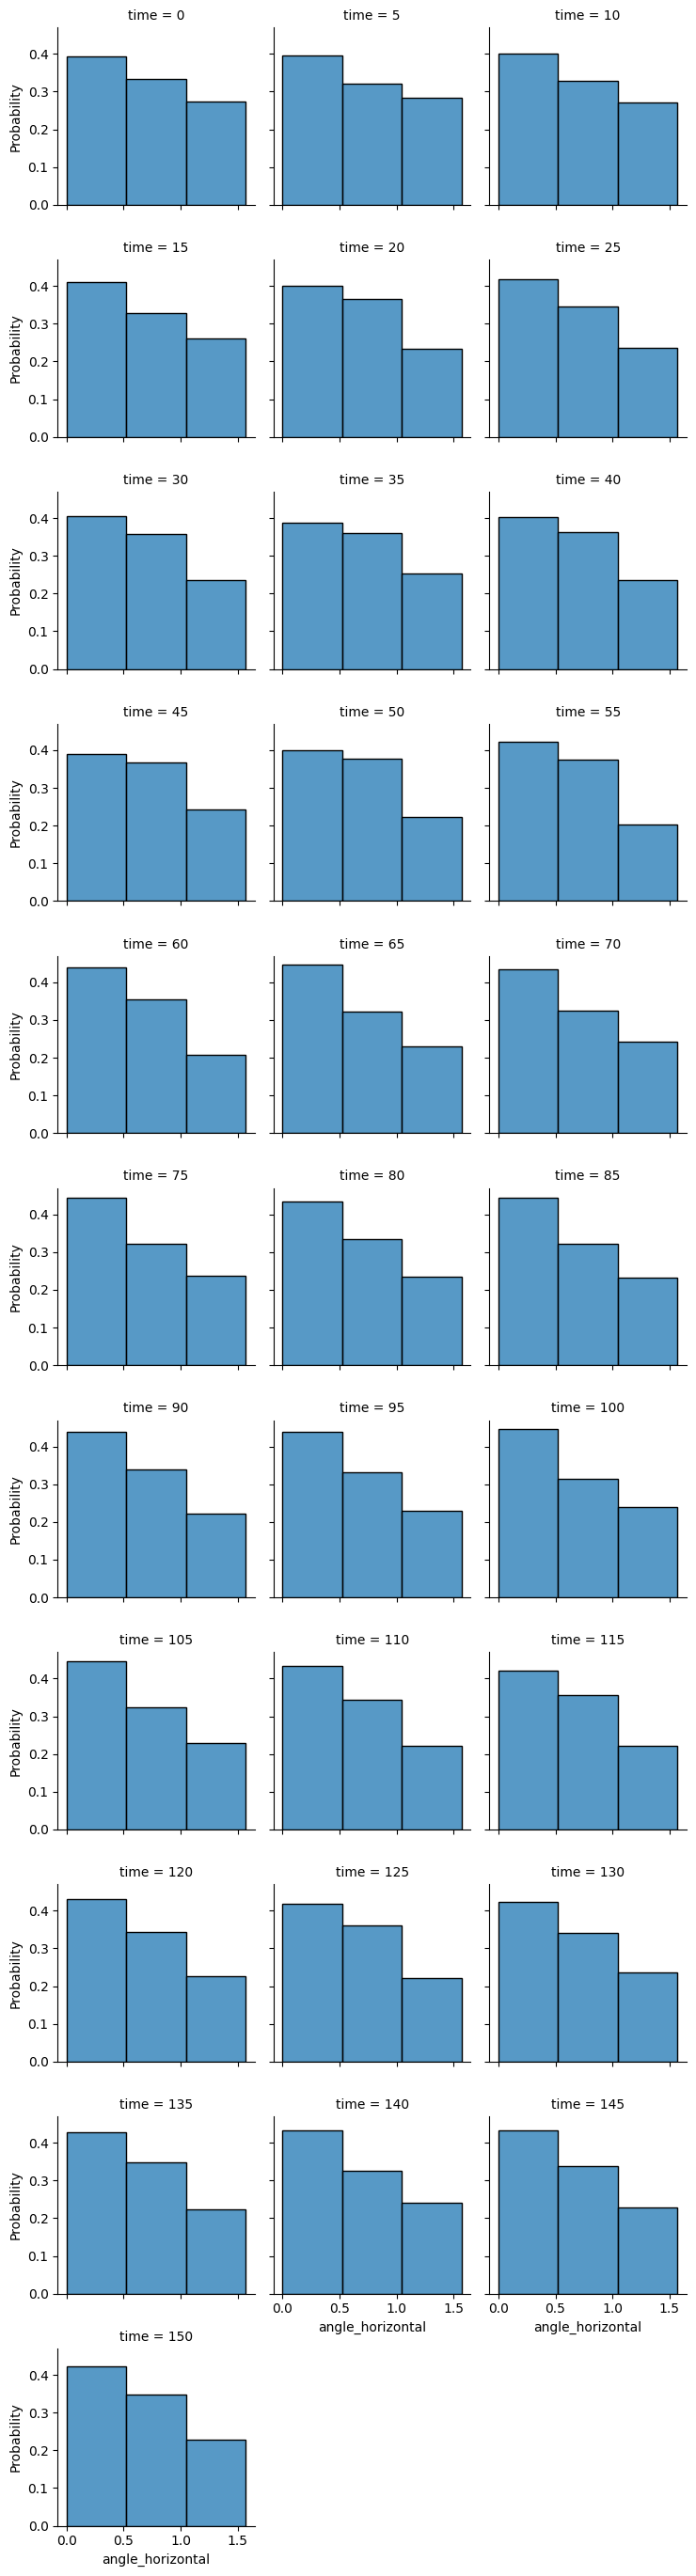

In [20]:
g = sns.FacetGrid(dat_df, col="time", height=2.5, col_wrap=3)
g.map(sns.histplot, "angle_horizontal", stat='probability', binrange=[0, np.pi/2],bins=3)

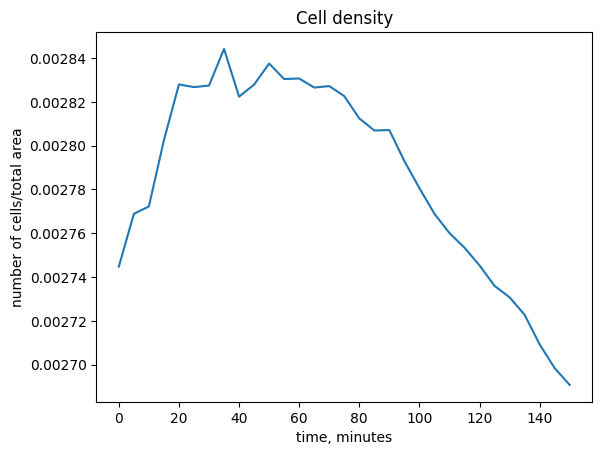

In [21]:
#cell density
plt.plot(dat_df.groupby('time').count().cell_id_new/(dat_df.groupby('time').cell_area_microns.sum()))
#plt.axvline(80, c='r', linestyle='--', linewidth=0.75)

plt.xlabel('time, minutes')
plt.ylabel('number of cells/total area')
plt.title("Cell density")

plt.savefig(plot_dir+'/cell_density_time.png', dpi=300, bbox_inches='tight')

In [10]:
cc_0=np.array([dat_df[dat_df.time==0].cc_x, dat_df[dat_df.time==0].cc_y]).T

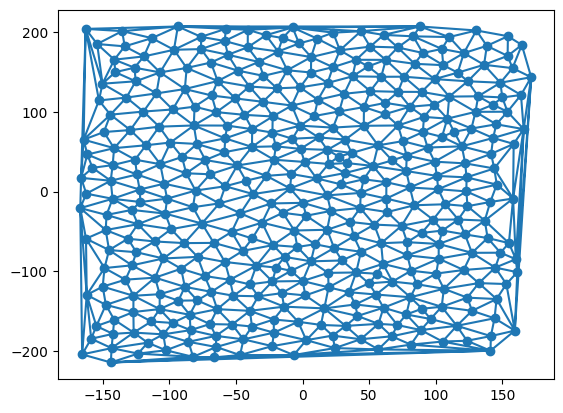

In [18]:
tri = Delaunay(cc_0)
plt.triplot(cc_0[:,0], cc_0[:,1], tri.simplices)
plt.scatter(cc_0[:,0], cc_0[:,1])



In [36]:
triangles = tri.simplices
# get all the unique edges 
all_edges = set([tuple(sorted(edge)) for item in triangles for edge in combinations(item,2)])
mean_dist=np.mean([np.linalg.norm(cc_0[edge[0]]-cc_0[edge[1]]) for edge in all_edges])

In [43]:
shell_matrix

NameError: name 'shell_matrix' is not defined

In [42]:
dat_df[dat_df.time==0].cell_area_microns.mean()

364.3250851617584